In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

try:
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

TensorFlow 2.x selected.
2.0.0


In [3]:
#再現性の確保
#for ensure reproducibility

import numpy as np
import tensorflow as tf
import random as rn

np.random.seed(5)


rn.seed(5)


session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

from keras import backend as K


tf.random.set_seed(5)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)


Using TensorFlow backend.


In [4]:

dataset_path="/content/drive/My Drive/test_regression_RNN_LSTM_for_sin/data/sin.csv"
dataset_path

'/content/drive/My Drive/test_regression_RNN_LSTM_for_sin/data/sin.csv'

In [5]:

raw_dataset = pd.read_csv(dataset_path,na_values = "?",skipinitialspace=True)
column_names = list(raw_dataset.columns)
print(column_names)
dataset = raw_dataset.copy()
dataset.tail()

['x', 't']


,x,t
506,251,-9.840028e-02
507,252,-7.385253e-02
508,253,-4.925994e-02
509,254,-2.463745e-02
510,255,-2.449294e-16


In [6]:
dataset.isna().sum()

x    0
t    0
dtype: int64

In [0]:
dataset = dataset.dropna()

In [8]:

dataset.tail()

,x,t
506,251,-9.840028e-02
507,252,-7.385253e-02
508,253,-4.925994e-02
509,254,-2.463745e-02
510,255,-2.449294e-16


In [0]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [10]:
train_stats = train_dataset.describe()
train_stats.pop("t")
train_stats = train_stats.transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
x,409.0,-2.591687,147.159784,-255.0,-129.0,-3.0,123.0,255.0


In [11]:
train_labels = train_dataset.pop('t')
test_labels = test_dataset.pop('t')
print(train_labels)
print(test_labels)

283    0.636474
100    0.626924
37     0.790532
46     0.905873
401   -0.440216
         ...   
279    0.557489
227   -0.636474
148   -0.483911
143   -0.372702
334    0.930229
Name: t, Length: 409, dtype: float64
9      0.219946
25     0.577774
28     0.636474
31     0.691698
32     0.709281
         ...   
486   -0.557489
493   -0.406737
494   -0.384106
497   -0.314870
509   -0.024637
Name: t, Length: 102, dtype: float64


In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [13]:
print([len(train_dataset.keys())])

[1]


In [0]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation  
from keras.layers.recurrent import LSTM


in_out_neurons = 1
hidden_neurons = 512
length_of_sequences = 100




def build_model():
  model = keras.Sequential([
    layers.LSTM(hidden_neurons, batch_input_shape=(None, len(train_dataset.keys()), in_out_neurons), return_sequences=False),
    layers.Dense(in_out_neurons),
    layers.Activation("linear")
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [0]:
model = build_model()

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 512)               1052672   
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 1,053,185
Trainable params: 1,053,185
Non-trainable params: 0
_________________________________________________________________


In [0]:
normed_train_data = normed_train_data.values.reshape(normed_train_data.values.shape[0],normed_train_data.values.shape[1],1)
normed_test_data = normed_test_data.values.reshape(normed_test_data.values.shape[0],normed_test_data.values.shape[1],1)
train_labels = train_labels.values.reshape(train_labels.values.shape[0],1,1)
test_labels = test_labels.values.reshape(test_labels.values.shape[0],1,1)

In [18]:
example_batch = normed_train_data[:10]
print(example_batch)
example_result = model.predict(example_batch)
example_result

[[[ 0.20788076]]

 [[-1.03566551]]

 [[-1.4637716 ]]

 [[-1.40261359]]

 [[ 1.00973026]]

 [[-1.10361886]]

 [[-0.09790931]]

 [[-1.61326897]]

 [[-0.01636529]]

 [[-0.13188598]]]


array([[ 0.00256619],
       [-0.01275215],
       [-0.01800134],
       [-0.01725242],
       [ 0.01247427],
       [-0.01358638],
       [-0.00120806],
       [-0.01983059],
       [-0.00020195],
       [-0.00162719]], dtype=float32)

In [19]:

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,0.003203,0.039533,0.003203,0.003382,0.045107,0.003382,995
996,0.003196,0.041244,0.003196,0.002666,0.034240,0.002666,996
997,0.003121,0.038945,0.003121,0.003001,0.038572,0.003001,997
998,0.003275,0.042778,0.003275,0.003867,0.044237,0.003867,998
999,0.003151,0.041510,0.003151,0.002293,0.037014,0.002293,999


In [21]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set loss: {:5.4f} t".format(loss))
print("Testing set MAE: {:5.4f} t".format(mae))
print("Testing set MSE: {:5.4f} t".format(mse))

102/1 - 0s - loss: 0.0066 - mae: 0.0337 - mse: 0.0020
Testing set loss: 0.0020 t
Testing set MAE: 0.0337 t
Testing set MSE: 0.0020 t


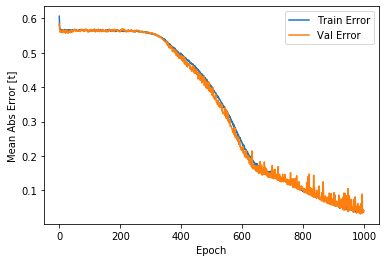

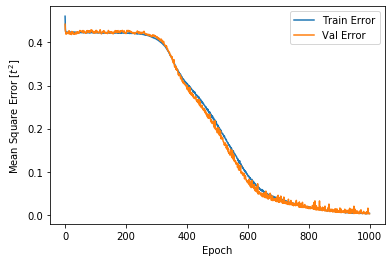

In [22]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [t]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$t^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.legend()
  plt.show()


plot_history(history)

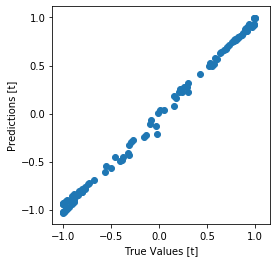

In [23]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [t]')
plt.ylabel('Predictions [t]')
plt.axis('equal')
plt.axis('square')
_ = plt.plot()

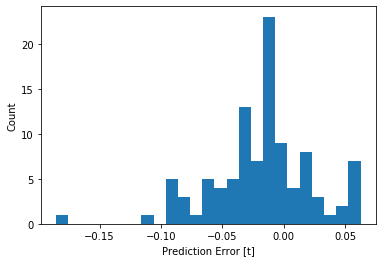

In [24]:
error = test_predictions - test_labels.reshape(test_labels.size)
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [t]")
_ = plt.ylabel("Count")

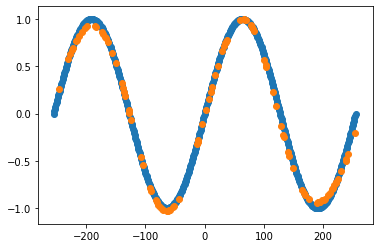

In [25]:

plt.scatter(raw_dataset['x'].values,raw_dataset['t'].values)
plt.scatter(normed_test_data.reshape(1,normed_test_data.size)*np.array(train_stats['std'])+np.array(train_stats['mean']),test_predictions)
plt.show()


..............

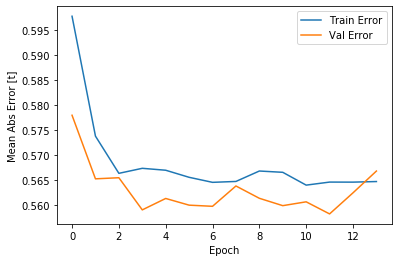

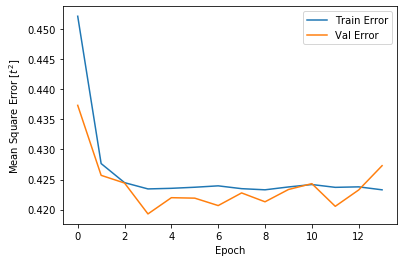

In [26]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [27]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
9,0.423765,0.566490,0.423765,0.423340,0.559821,0.423340,9
10,0.424168,0.563928,0.424168,0.424316,0.560588,0.424316,10
11,0.423700,0.564536,0.423700,0.420551,0.558169,0.420551,11
12,0.423782,0.564525,0.423782,0.423265,0.562385,0.423265,12
13,0.423290,0.564644,0.423290,0.427296,0.566743,0.427296,13


In [28]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set loss: {:5.2f} t".format(loss))
print("Testing set MAE: {:5.2f} t".format(mae))
print("Testing set MSE: {:5.2f} t".format(mse))

102/1 - 0s - loss: 0.2418 - mae: 0.5693 - mse: 0.4362
Testing set loss:  0.44 t
Testing set MAE:  0.57 t
Testing set MSE:  0.44 t


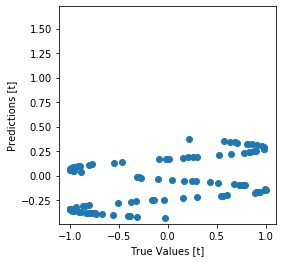

In [29]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [t]')
plt.ylabel('Predictions [t]')
plt.axis('equal')
plt.axis('square')
_ = plt.plot()

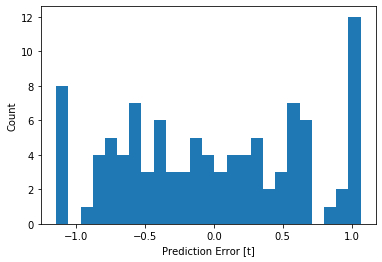

In [30]:

error = test_predictions - test_labels.reshape(test_labels.size)
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [t]")
_ = plt.ylabel("Count")

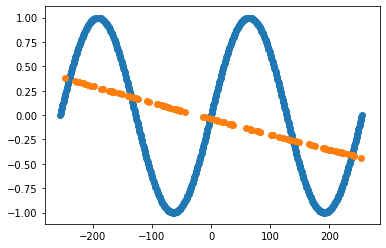

In [31]:
plt.scatter(raw_dataset['x'].values,raw_dataset['t'].values)
plt.scatter(normed_test_data.reshape(1,normed_test_data.size)*np.array(train_stats['std'])+np.array(train_stats['mean']),test_predictions)
plt.show()